$ \newcommand{\bra}[1]{\langle #1|} $
$ \newcommand{\ket}[1]{|#1\rangle} $
$ \newcommand{\braket}[2]{\langle #1|#2\rangle} $
$ \newcommand{\ketbra}[2]{| #1\rangle \langle #2|} $
$ \newcommand{\tr}{{\rm tr}} $
$ \newcommand{\i}{{\color{blue} i}} $
$ \newcommand{\Hil}{{\cal H}} $
$ \newcommand{\V}{{\cal V}} $
$ \newcommand{\bn}{{\bf n}} $


# 3. Qubit spectroscopy

Pulses give grain-level access to the transmon dynamics, like excitation to higher energy states. In this notebook we'll see how the qubit responds to pulses with different frequencies, exploring some observable fenemona at Qmio.


## 3.1. Measuring the anharmonicity

When we studied pulses for gate implementation, made a series of assumtions: 

- We only considered the two computational energy levels of the transmon.

- We set the driving frequency at the resonance of the qubit.

But in reality, transmons have higher energy levels that can be accessed by microwave pulses. For example, the second excited state $\ket{2}$ can be reached if we know the anharmonicity $\alpha$ of the qubit. We could apply a pulse of frequency $\omega_q+\alpha$ to promote from $\ket{1}$ to $\ket{2}$, or one with frequency $2\omega_q+\alpha$ to promote directly from $\ket{0}$. But, how can we measure these higher energy states? These states also produce a shift in the energy levels of the driven resonator, inducing a distinct observable response. When working with IQ-mixing readout, this would result in clouds on the IQ plane different from $\ket{0}$ and $\ket{1}$.<br>
<br>

Unfortunatetly, in Qmio we don't have access to these IQ measurements, only to their projection to the $\ket{0}$-$\ket{1}$ bisector. This is a problem especially for the case of $\ket{2}$, as its cloud lands right above $\ket{1}$, making them practically undistinguishable from their bisector projection. This means that we can't directly measure $\omega_{12}$ or even $\omega_{02}$, as it would lead to a high error from the readout.


## 3.2. Spectroscopy with OpenPulse

A qubit spectroscopy consists of sweeping the driving frequencies for an X gate calibrated pulse and observing the response. The expected behaviour is a peak around the resonance frequency, corresponding to the $\ket{0}$-$\ket{1}$ transition.<br>
<br>

To change the pulses' frequency, we must do it by modifying the driving frame. In OpenPulse, this can be achieved with two functions:

- **```set_frequency(frame, float)```**: sets the frequency to some value.

- **```shift_frequency(frame, float)```**: shift the frequency by some value.

This functions can only be invoked in calibration blocks (```cal``` and ```defcal```).<br>
<br> 

In [1]:
from qmio import QmioRuntimeService
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

service = QmioRuntimeService()

def run_instruction(_backend, _instruction, _shots):  
        _res = _backend.run(circuit = _instruction, shots = _shots, res_format = 'raw')     
        try :
            return _res["results"].reshape((_shots,))                                      
        except :
            print(_res) 

In [2]:
qubit = 8

# Saturation pulse setting
amplitude = 0.04646
duration = 500 # dt
sigma = 100 # dt

def set_freq(_freq):
    _inst = f'''OPENQASM 3;
    defcalgrammar "openpulse";

    cal {{
        extern frame q{qubit}_drive;
        set_frequency(q{qubit}_drive, {_freq});
        waveform wf = gaussian({amplitude}, {duration}dt, {sigma}dt);
    }}

    defcal custom_pulse ${qubit} {{
        play(q{qubit}_drive, wf);
    }}

    custom_pulse ${qubit};
    measure ${qubit};'''
    return _inst

def plot_spectrum(_freqs, _res):
    plt.plot(_freqs, _res)
    plt.ylabel(r'$|0\rangle$ counts')
    plt.xlabel('Frequency (Hz)')
    plt.show()

In [6]:
# Frequency sweep settings
freq_start = 4.20e9
freq_end = 4.60e9
freq_step = 0.001e9
freq_sweep = np.arange(freq_start, freq_end, freq_step)

shots = 1000

results = []
with service.backend(name = "qpu") as backend:
    for f in freq_sweep:
        instruction = set_freq(f)
        res = run_instruction(backend, instruction, shots)
        results.append(len(np.where(res>0)[0])/shots)

Waiting for resources
Waiting for resources


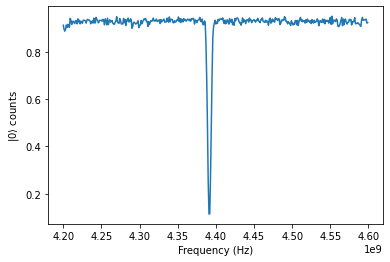

In [7]:
plot_spectrum(freq_sweep, results)

In [16]:
f01 = freq_sweep[np.where(np.array(results) == np.min(results))][0]
print(f't01 frequency: {f01:0.4e} Hz')

t01 frequency: 4.3910e+09 Hz


## 3.3. Experiments

### Measuring anharmonicity via two-photon absorption

To measure the qubit's anharmonicity, the most direct method would be to first apply an X gate an then perform spectroscopy. If we could differentiate the states, we would see two peaks: one corresponding to the stimulated emission $\ket{1}\rightarrow\ket{0}$, and other corresponding to the absorption $\ket{1}\rightarrow\ket{2}$. Measuring the frequency where this last transition happens would give us the desired value, as:
$$\alpha = \omega_{12}-\omega_{01}.$$
Unfortunatetly, we can't differentiate $\ket{2}$ from $\ket{1}$, only observing the stimulated emission in the spectrometry.<br>
<br>

The **two-photon absorption (TPA)** is the simultaneous absorption of two photons -with or without identical frequencies- where the system is promoted through a virtual energy level. In our case, this effect can promote the system from $\ket{0}$ to $\ket{2}$ with photons of frequency $\omega_q+\alpha/2$. <br>
<br>

Why is the convenient? First, we don't need to access the first excited state to promote to $\ket{2}$, so we can classify all the measurements in the bisector as $\ket{2}$ with minimal readout error. Second, this frequency is close to the operative frequency of the qubit, much more convenient than the one for the one-photon absorption from $\ket{0}$-$\ket{2}$. If we measure the transition frequency for $\ket{0}\rightarrow\ket{2}$, we can easily compute the anharmonicity:

$$\begin{align*}
\omega_{02} &= \omega_{01} + \omega_{12} = 2\omega_{01} + \alpha,\\
\\
\alpha &= \omega_{02} - 2\omega_{01}.
\end{align*}$$


What we need to keep in mind is that TPA depends on the simultaneous absorption of two photons, having a lower probability of happening compared to one-photon absorptions, which would lead to a less populated $\ket{2}$ for a same pulse intensity. This means that we need to use higher amplitudes for the pulses in order to observe this process. Having that in mind, we can use our contant pulse calibration to reduce its duration -remember that for a contant pulse, amplitude times duration is constant for the X gate- in order to achieve a high-amplitude calibrated pulse. In this case, we chose the minimum duration possible: 32ns (64dt).

In [17]:
qubit = 8

# Saturation pulse setting
amplitude = 0.1736
duration = 64 # dt

def set_freq(_freq):
    _inst = f'''OPENQASM 3;
    defcalgrammar "openpulse";

    cal {{
        extern frame q{qubit}_drive;
        set_frequency(q{qubit}_drive, {_freq});
        waveform wf = constant({duration}dt, {amplitude});
    }}

    defcal custom_pulse ${qubit} {{
        play(q{qubit}_drive, wf);
    }}

    custom_pulse ${qubit};
    measure ${qubit};'''
    return _inst

In [18]:
# Frequency sweep settings
freq_start = 4.20e9
freq_end = 4.60e9
freq_step = 0.001e9
freq_sweep = np.arange(freq_start, freq_end, freq_step)

shots = 1000

results = []
with service.backend(name = "qpu") as backend:
    for f in freq_sweep:
        instruction = set_freq(f)
        res = run_instruction(backend, instruction, shots)
        results.append(len(np.where(res>0)[0])/shots)

Waiting for resources
Waiting for resources


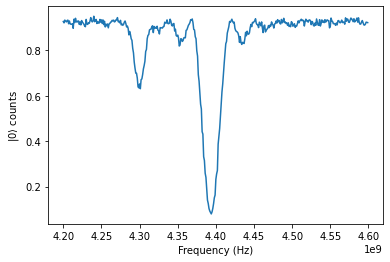

In [19]:
plot_spectrum(freq_sweep, results)

As you can see, a new smaller resonance has appeared on the spectrometry, next to the main qubit's resonance. To achieve a more precise measurement of its frequency, we are going to perform a more dense sweep around this secondary peak.

In [20]:
# Frequency sweep settings
freq_start = 4.25e9
freq_end = 4.35e9
freq_step = 0.0005e9
freq_sweep = np.arange(freq_start, freq_end, freq_step)

shots = 1000

results = []
with service.backend(name = "qpu") as backend:
    for f in freq_sweep:
        instruction = set_freq(f)
        res = run_instruction(backend, instruction, shots)
        results.append(len(np.where(res>0)[0])/shots)

Waiting for resources


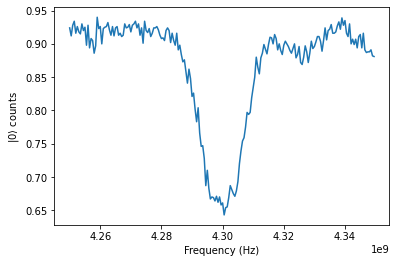

In [21]:
plot_spectrum(freq_sweep, results)

In [27]:
f02 = 2 * freq_sweep[np.where(np.array(results) == np.min(results))][0]
alpha = f02 - 2 * f01
f12 = f01 + alpha
print(f't01 frequency: {f01:0.4e} Hz')
print(f't12 frequency: {f12:0.4e} Hz')
print(f't02 frequency: {f02:0.4e} Hz')
print(f'Anharmonicity: {alpha:0.4e} Hz')

t01 frequency: 4.3910e+09 Hz
t12 frequency: 4.2100e+09 Hz
t02 frequency: 8.6010e+09 Hz
Anharmonicity: -1.8100e+08 Hz


The measured anharmonicity corresponds to the expected range for Qmio's qubits.

 ### 2nd excited state gate calibration
 Now, we'll try to calibrate a $\ket{0}\rightarrow\ket{2}$ gate.

In [19]:
qubit = 8
duration = 500
sigma = 64
freq = 8.6010e+09/2

def build_gaussian(_amp):
    _instruction = f'''
    OPENQASM 3;
    defcalgrammar "openpulse";
        
    cal {{
        extern frame q{qubit}_drive;
        set_frequency(q{qubit}_drive, {freq});
        waveform wf = gaussian({_amp}, {duration}dt, {sigma}dt);
    }}

    defcal custom_pulse ${qubit}{{
        play(q{qubit}_drive, wf);
    }}

    custom_pulse ${qubit};
    measure ${qubit};
    '''
    return _instruction

In [21]:
def plot_data(_amps, _p0):
    plt.plot(_amps, _p0)
    plt.xlabel(r'Amplitude')
    plt.ylabel(r'$P_0$')


amps = np.linspace(0.0, 0.8, 100)
shots = 700

p0 = []

with service.backend(name = "qpu") as backend:  
    for a in amps:
        instruction = build_gaussian(a)
        res = run_instruction(backend, instruction, shots)
        p0.append(len(np.where(res>0)[0])/shots)


Waiting for resources


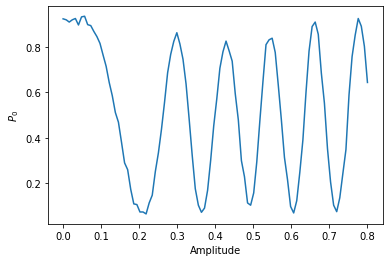

In [22]:
plot_data(amps, p0)

In [26]:
t02_amp = amps[np.where(p0 == np.min(p0))][0]
fid_cal = 1- np.array(p0)[np.where(p0 == np.min(p0))][0]
                       
print(f'Gaussian calibration duration: {duration}dt')
print(f'Gaussian calibration sd: {sigma}dt')
print(f'Gaussian calibrated amplitude: {t02_amp:0.5f}')
print(f'Gaussian calibration fidelity: {fid_cal:0.5f}')

Gaussian calibration duration: 500dt
Gaussian calibration sd: 64dt
Gaussian calibrated amplitude: 0.21818
Gaussian calibration fidelity: 0.93714


### Excited statets on the bisector

Finally, let's compare states $\ket{1}$ and $\ket{2}$ on the bisector:

In [42]:
qubit = 8
X01 = f'''
    OPENQASM 3;
    x ${qubit};
    measure ${qubit};
    '''

freq = 8.6010e+09/2 # Hz
amp = 0.21818
duration = 500 # dt
sigma = 64 # st

X02 = f'''
    OPENQASM 3;
    defcalgrammar "openpulse";
        
    cal {{
        extern frame q{qubit}_drive;
        set_frequency(q{qubit}_drive, {freq});
        waveform wf = gaussian({amp}, {duration}dt, {sigma}dt);
    }}

    defcal custom_pulse ${qubit}{{
        play(q{qubit}_drive, wf);
    }}

    custom_pulse ${qubit};
    x ${qubit};
    measure ${qubit};
    '''

In [43]:
shots = 10000
with service.backend(name = "qpu") as backend:  
    res01 = run_instruction(backend, X01, shots)
    res02 = run_instruction(backend, X02, shots)

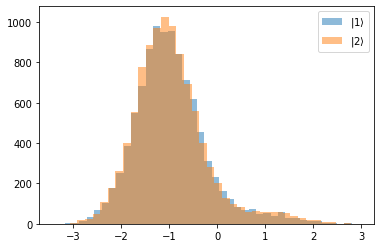

In [47]:
plt.hist(res01, bins = 40, alpha = 0.5, label = r'$|1\rangle$')
plt.hist(res02, bins = 40, alpha = 0.5, label = r'$|2\rangle$')
plt.legend()
plt.show()

### Mollow peaks